
Verwendetes Szenario: office
Ladepunkte: 15
Zeitraum: 2025-12-01 00:00:00 bis 2025-12-02 23:45:00
Horizont: 2 Tage

📊 Sessions
Ankünfte mit Ladebedarf: 73
mit Ladezugang: 39
ohne Ladezugang (drive_off): 34
Nicht erreicht: 1


,session_id,vehicle_name,vehicle_class,arrival_time,departure_time,parking_hours,delivered_energy_kwh,remaining_energy_kwh,charger_id
0,2025-12-02_8,Air Grand Touring,PKW,2025-12-02 08:27:24.063837,2025-12-02 09:14:53.300478,0.791455,71.25,15.57823,7


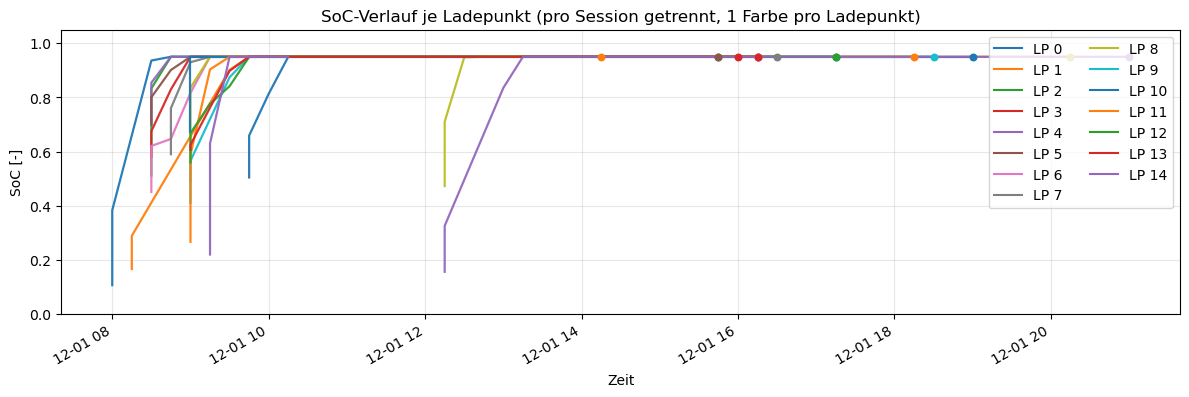

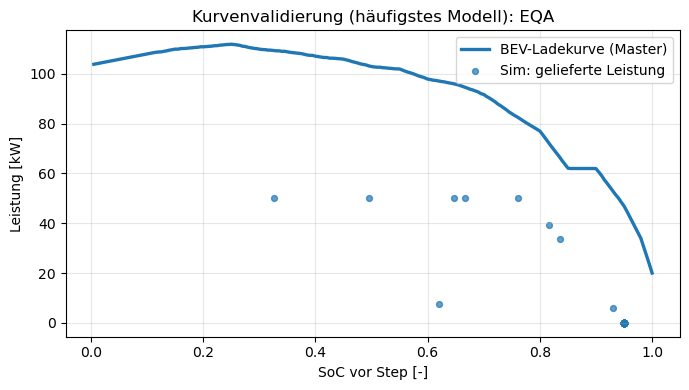

Verstöße: 0


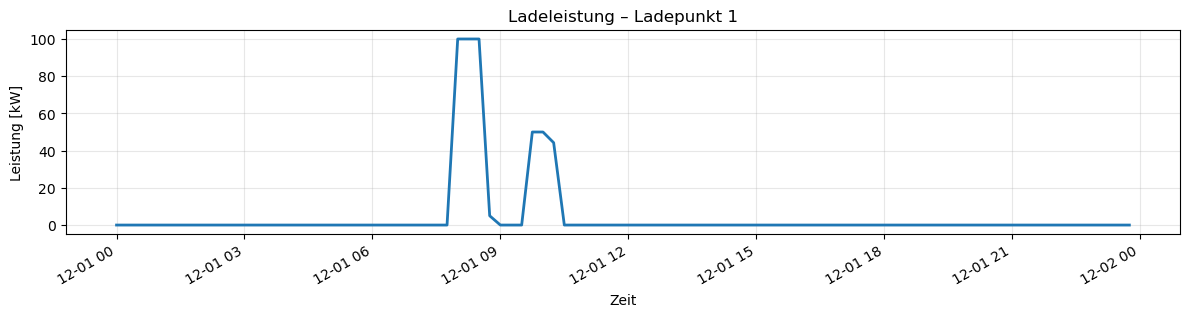

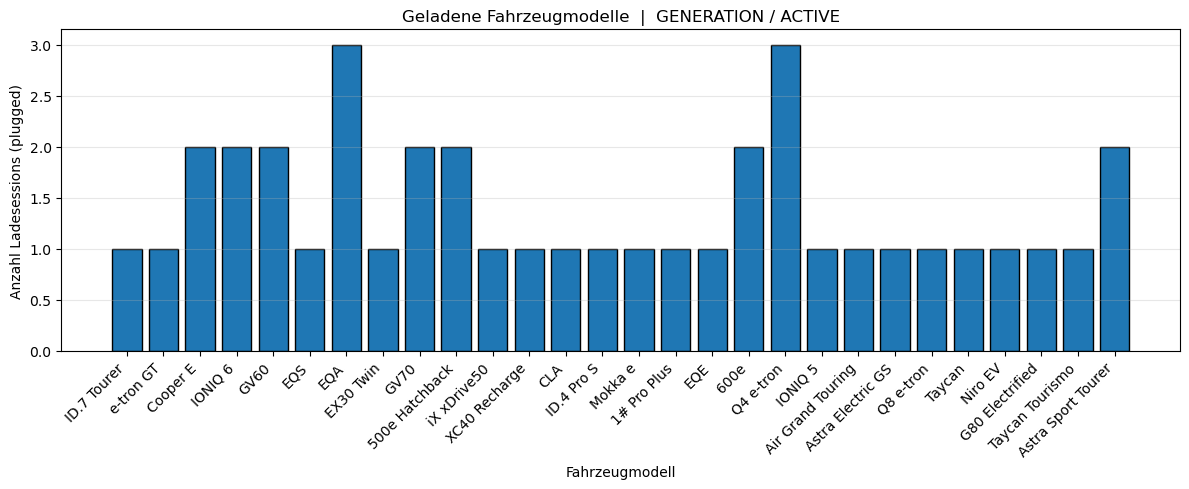

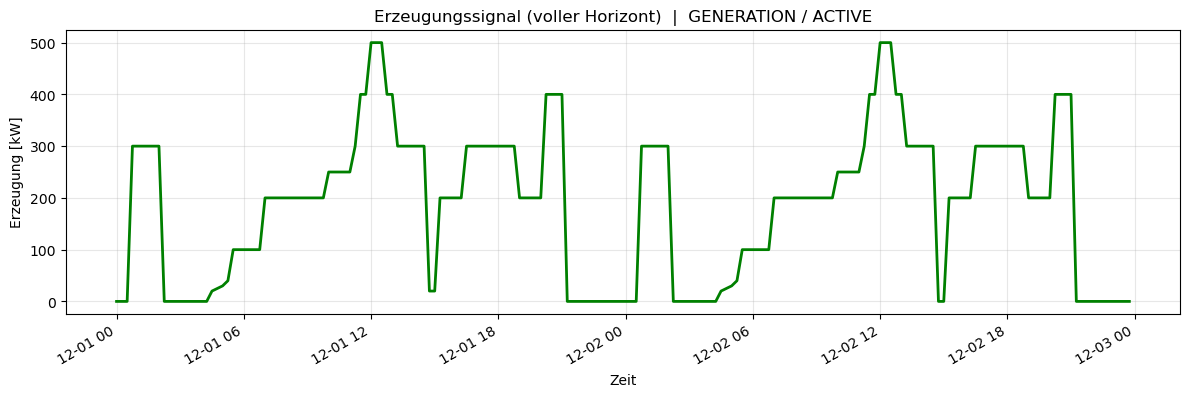

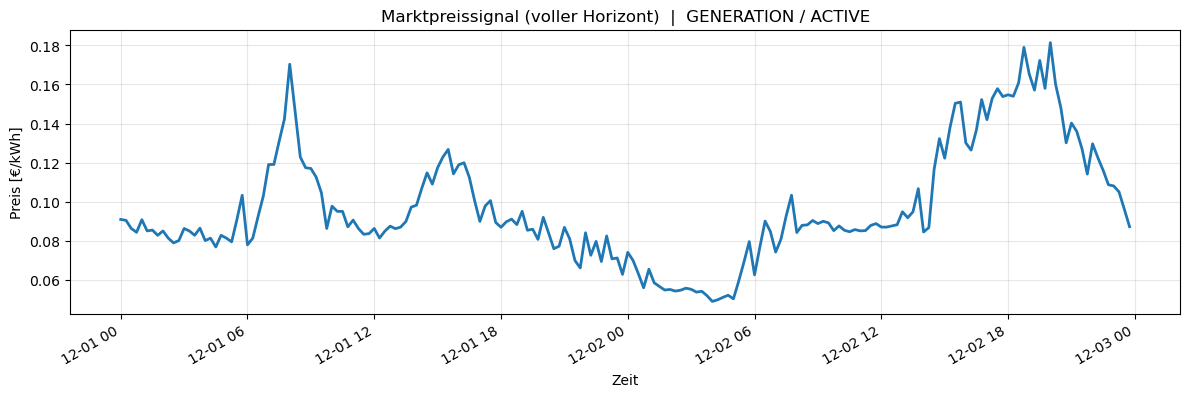

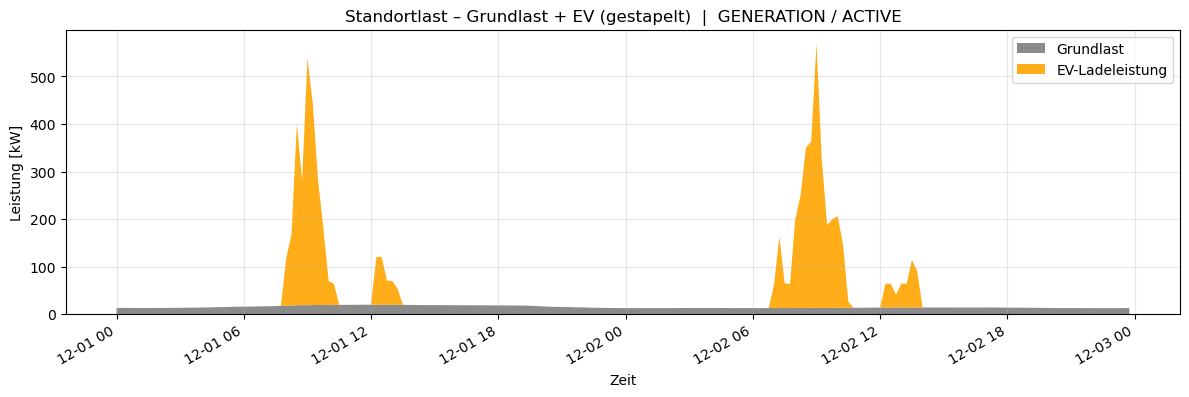

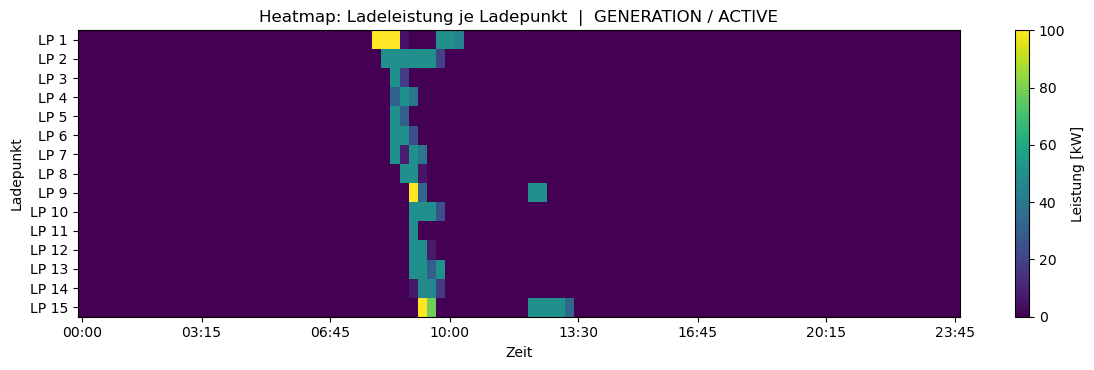

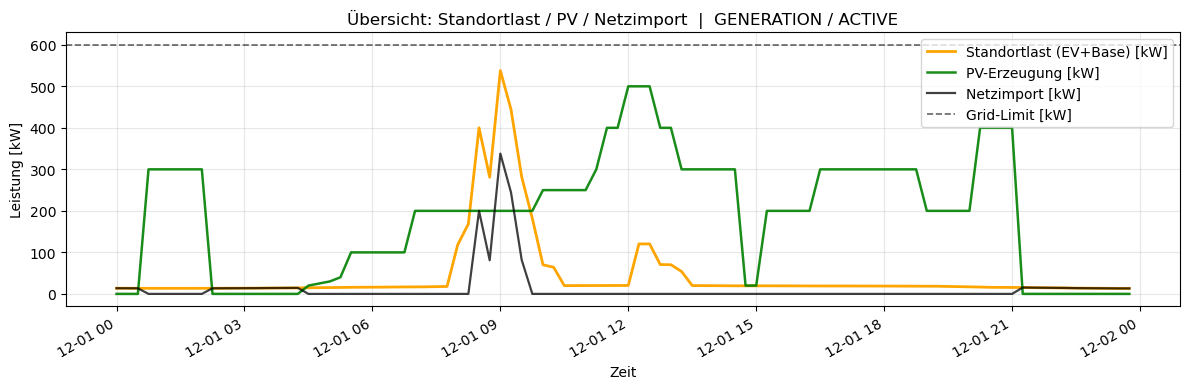

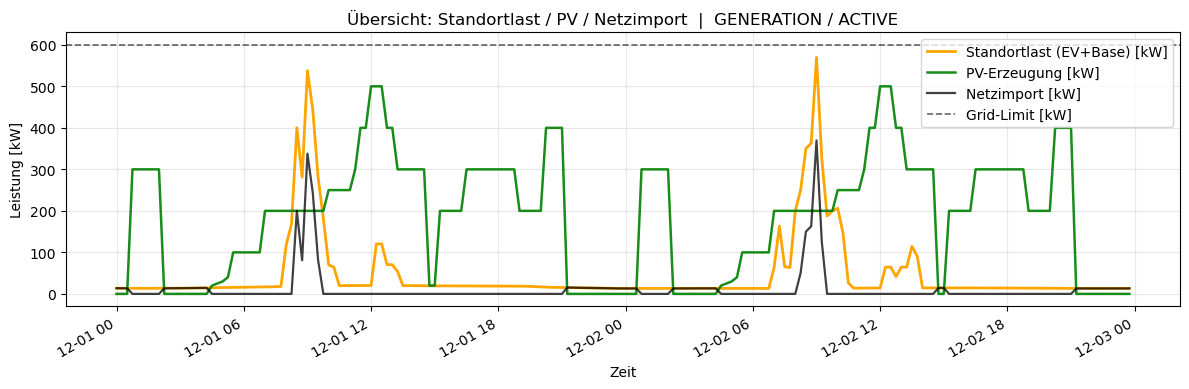

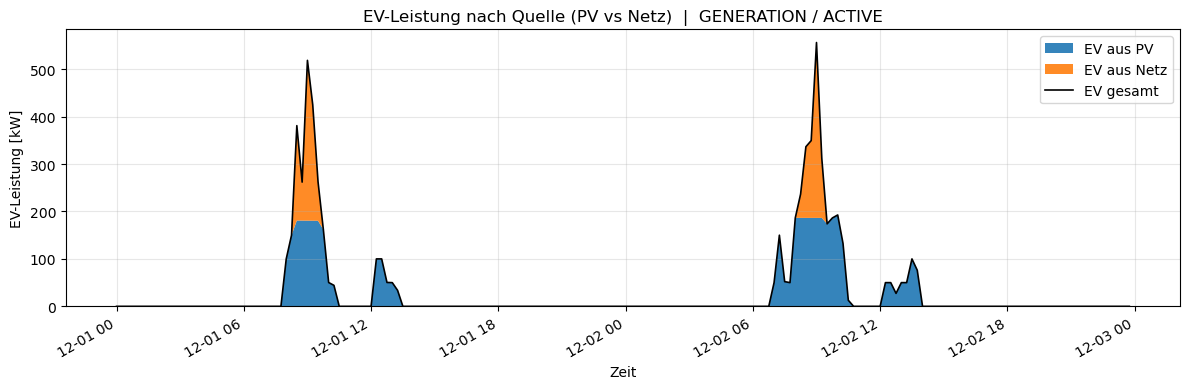

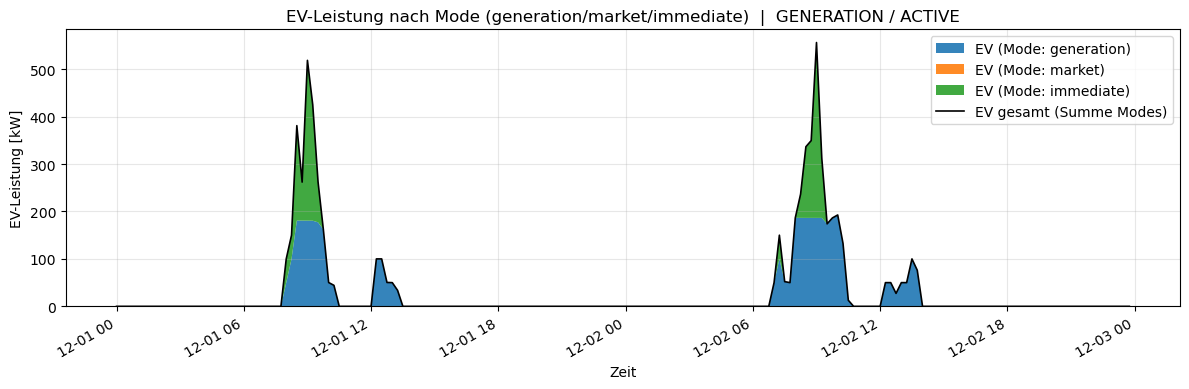

,vehicle_name,date,arrival_time,departure_time,parking_hours,delivered_energy_kwh,remaining_energy_kwh,charger_id
0,ID.7 Tourer,2025-12-01,07:53,09:41,1.79,72.43,0.0,0
1,e-tron GT,2025-12-01,08:05,14:29,6.40,75.93,0.0,1
2,Cooper E,2025-12-01,08:16,15:51,7.58,16.19,0.0,2
3,IONIQ 6,2025-12-01,08:20,16:03,7.72,28.47,0.0,3
4,GV60,2025-12-01,08:27,16:23,7.93,19.25,0.0,4
5,EQS,2025-12-01,08:28,15:53,7.43,29.50,0.0,5
6,EQA,2025-12-01,08:29,16:15,7.77,34.90,0.0,6
7,EQA,2025-12-01,08:30,16:37,8.11,25.15,0.0,7
8,EX30 Twin,2025-12-01,08:47,10:17,1.50,31.61,0.0,8
9,GV70,2025-12-01,08:51,18:43,9.87,41.44,0.0,9



🧩 Nutzung der Lademodi – Sessions
Sessions mit Ladevorgang: 39
PV: 32
Market: 0
Immediate: 25
Mehrere Modi: 18

⚡ Energie nach Modus [kWh]
Generation: 976.97
Market:     0.00
Immediate:  464.69
max |grid - bilanz| = 0.0


,ts,ev_load_kw,base_load_kw,site_load_kw,pv_generation_kw,grid_import_kw_site,grid_import_kw_site_calc,diff
0,2025-12-01,0.0,13.6272,13.6272,0.0,13.6272,13.6272,0.0


In [5]:
# =============================================================================
# run_simulation.ipynb  (als .py-Zelle-Block lesbar) – AUFGERÄUMT
# =============================================================================

# =============================================================================
# A) GLOBAL SETUP – einmal ganz oben ausführen
# =============================================================================
scenario_name = "office"
scenario_path = f"../scenarios/{scenario_name}.yaml"

steps_per_day = None
t0 = None
t1 = None


def init_time_window(timestamps, scenario: dict, days: int = 1):
    """
    Diese Funktion bestimmt ein Zoom-Fenster (t0, t1) basierend auf der Szenarioauflösung.

    Verhalten:
      - Es wird ein Fenster der Länge 'days' Tage ab dem ersten Timestamp gewählt.
      - Die Funktion liefert zusätzlich steps_per_day zurück.
    """
    if timestamps is None or len(timestamps) == 0:
        return None, None, None
    steps_per_day_local = int(24 * 60 / int(scenario["time_resolution_min"]))
    steps = int(max(1, days)) * steps_per_day_local
    t0_local = pd.to_datetime(timestamps[0])
    t1_local = pd.to_datetime(timestamps[min(len(timestamps) - 1, steps - 1)])
    return steps_per_day_local, t0_local, t1_local


# =============================================================================
# B) Imports
# =============================================================================
import sys
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from datetime import datetime
from IPython.display import display, HTML

warnings.simplefilter("always", UserWarning)

# Plot-Farben (global konsistent)
COLOR_GENERATION = "green"
COLOR_LOAD = "orange"
COLOR_BASELOAD = "#7f7f7f"
COLOR_MARKET = "tab:blue"


# =============================================================================
# C) Notebook UI Helpers
# =============================================================================
def show_strategy_status_html(charging_strategy: str, strategy_status: str) -> None:
    """
    Diese Funktion zeigt im Notebook eine farbige Statusbox an, die Strategie und Status visualisiert.
    """
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()
    color_map = {"ACTIVE": "#1a7f37", "INACTIVE": "#c62828", "IMMEDIATE": "#616161"}
    emoji_map = {"ACTIVE": "🟢", "INACTIVE": "🔴", "IMMEDIATE": "⚪"}
    color = color_map.get(status, "#616161")
    emoji = emoji_map.get(status, "⚪")
    html = f"""
    <div style="font-size:18px;font-weight:800;color:{color};
        padding:10px 12px;border:2px solid {color};border-radius:12px;
        display:flex;align-items:center;gap:10px;width:fit-content;margin:8px 0 14px 0;
        background: rgba(0,0,0,0.02);">
      <span style="font-size:22px">{emoji}</span>
      <div>
        <div>Charging strategy: <span style="letter-spacing:0.5px">{strat}</span></div>
        <div>Strategy status: <span style="letter-spacing:0.5px">{status}</span></div>
      </div>
    </div>"""
    display(HTML(html))


def decorate_title_with_status(base_title: str, charging_strategy: str, strategy_status: str) -> str:
    """
    Diese Funktion ergänzt einen Plot-Titel um Strategie und Status.
    """
    status = (strategy_status or "IMMEDIATE").upper()
    strat = (charging_strategy or "immediate").upper()
    return f"{base_title}  |  {strat} / {status}"


# =============================================================================
# D) Projektpfad setzen, damit "model" importierbar ist
# =============================================================================
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)


# =============================================================================
# E) Imports aus dem Simulationsmodul
# =============================================================================
from model.simulation import (
    load_scenario,
    simulate_load_profile,
    build_base_load_series,
    summarize_sessions,
    get_daytype_calendar,
    group_sessions_by_day,
)

try:
    from model.simulation import build_strategy_signal_series
except Exception:
    build_strategy_signal_series = None

try:
    from model.simulation import summarize_sessions_by_charging_mode, summarize_energy_by_charging_mode
except Exception:
    summarize_sessions_by_charging_mode = None
    summarize_energy_by_charging_mode = None


# =============================================================================
# F) Simulation ausführen
# =============================================================================
scenario = load_scenario(scenario_path)

(
    timestamps,
    load_kw,
    sessions,
    charging_counts,
    holiday_dates,
    charging_strategy,
    strategy_status,
    debug_rows,
    charger_traces,
) = simulate_load_profile(
    scenario,
    record_debug=True,
    record_charger_traces=True,
)

show_strategy_status_html(charging_strategy, strategy_status)

df_tr = pd.DataFrame(charger_traces if charger_traces is not None else [])
steps_per_day, t0, t1 = init_time_window(timestamps=timestamps, scenario=scenario, days=1)


# =============================================================================
# G) Optional: Strategie-Signale (PV / Market)
# =============================================================================
generation_series = generation_ylabel = None
market_series = market_ylabel = None

if build_strategy_signal_series is not None:
    if charging_strategy.lower() == "generation":
        generation_series, generation_ylabel = build_strategy_signal_series(
            scenario=scenario,
            timestamps=timestamps,
            charging_strategy="generation",
            normalize_to_internal=True,
            strategy_resolution_min=15,
        )
        market_series, market_ylabel = build_strategy_signal_series(
            scenario=scenario,
            timestamps=timestamps,
            charging_strategy="market",
            normalize_to_internal=True,
            strategy_resolution_min=15,
        )
    elif charging_strategy.lower() == "market":
        market_series, market_ylabel = build_strategy_signal_series(
            scenario=scenario,
            timestamps=timestamps,
            charging_strategy="market",
            normalize_to_internal=True,
            strategy_resolution_min=15,
        )


# =============================================================================
# H) Timeseries DF (Debug = Source of Truth, fallback sonst)
# =============================================================================
def make_timeseries_df(timestamps, ev_load_kw, scenario, debug_rows=None, generation_series=None, market_series=None):
    """
    Diese Funktion baut ein konsistentes Timeseries-DataFrame für Auswertungen und Plots.

    Priorität:
      1) debug_rows (wenn vorhanden) werden gemerged und als "Source of Truth" genutzt.
      2) Base Load wird aus Debug genommen; falls fehlt, wird sie über build_base_load_series nachgeladen.
      3) Standortlast wird immer als ev_load_kw + base_load_kw gebildet.
      4) PV/Market-Signale werden ergänzt, wenn vorhanden.
    """
    df = pd.DataFrame({"ts": pd.to_datetime(timestamps), "ev_load_kw": np.asarray(ev_load_kw, float)})

    # Debug zuerst mergen
    if debug_rows is not None:
        df_dbg = pd.DataFrame(debug_rows).copy()
        if len(df_dbg) and "ts" in df_dbg.columns:
            df_dbg["ts"] = pd.to_datetime(df_dbg["ts"], errors="coerce")
            df_dbg = df_dbg.dropna(subset=["ts"]).drop_duplicates(subset=["ts"], keep="first")
            df = df.merge(df_dbg, on="ts", how="left")

    # Base Load: Debug bevorzugen, sonst berechnen
    if "base_load_kw" not in df.columns or df["base_load_kw"].isna().all():
        base = build_base_load_series(scenario=scenario, timestamps=timestamps, base_load_resolution_min=15)
        if base is None:
            base = np.zeros_like(df["ev_load_kw"].values)
        df["base_load_kw"] = np.asarray(base, float)

    # Standortlast konsistent
    df["site_load_kw"] = df["ev_load_kw"] + df["base_load_kw"]

    # PV: wenn Debug fehlt, aus Signal; wenn Debug vorhanden, Signal separat behalten
    if generation_series is not None:
        if "pv_generation_kw" not in df.columns or df["pv_generation_kw"].isna().all():
            df["pv_generation_kw"] = np.asarray(generation_series, float)
        else:
            df["pv_signal_kw"] = np.asarray(generation_series, float)

    # Market: analog
    if market_series is not None:
        if "price_eur_per_kwh" not in df.columns or df["price_eur_per_kwh"].isna().all():
            df["price_eur_per_kwh"] = np.asarray(market_series, float)
        else:
            df["price_signal_eur_per_kwh"] = np.asarray(market_series, float)

    return df


df_ts = make_timeseries_df(
    timestamps=timestamps,
    ev_load_kw=load_kw,
    scenario=scenario,
    debug_rows=debug_rows,
    generation_series=generation_series,
    market_series=market_series,
)


# =============================================================================
# I) KPIs kurz
# =============================================================================
print("\nVerwendetes Szenario:", scenario_name)
print("Ladepunkte:", scenario["site"]["number_chargers"])
print("Zeitraum:", timestamps[0], "bis", timestamps[-1])
print("Horizont:", scenario["simulation_horizon_days"], "Tage")

summary = summarize_sessions(sessions)
print("\n📊 Sessions")
print("Ankünfte mit Ladebedarf:", summary["num_sessions_total"])
print("mit Ladezugang:", summary["num_sessions_plugged"])
print("ohne Ladezugang (drive_off):", summary["num_sessions_rejected"])

df_not_reached = pd.DataFrame(summary["not_reached_rows"])
if len(df_not_reached) == 0:
    print("Alle BEV haben Ziel-SoC erreicht.")
else:
    df_not_reached = df_not_reached.sort_values("remaining_energy_kwh", ascending=False).reset_index(drop=True)
    print("Nicht erreicht:", len(df_not_reached))
    display(df_not_reached)


# =============================================================================
# J) Daytype Kalender (optional)
# =============================================================================
start_dt = datetime.fromisoformat(scenario["start_datetime"])
horizon_days = int(scenario["simulation_horizon_days"])
days_by_type_calendar = get_daytype_calendar(
    start_datetime=start_dt,
    horizon_days=horizon_days,
    holiday_dates=holiday_dates,
)
sessions_by_day = group_sessions_by_day(sessions, only_plugged=False)
sessions_by_day_plugged = group_sessions_by_day(sessions, only_plugged=True)


# =============================================================================
# K) Plot-Funktionen
# =============================================================================
def plot_soc_by_chargers(df_tr, charger_ids=None, start=None, end=None, use_raw=True):
    """
    Diese Funktion plottet den SoC-Verlauf je Ladepunkt.
    Pro Ladepunkt wird eine Farbe verwendet, Sessions werden als getrennte Linien dargestellt.

    Option:
      - use_raw=True nutzt soc_raw (ungeclamped), sonst soc (clamped).
    """
    if df_tr is None or len(df_tr) == 0:
        print("plot_soc_by_chargers: df_tr leer.")
        return

    req = {"ts","charger_id","occupied","session_id","soc","soc_raw"}
    if not req.issubset(df_tr.columns):
        print("plot_soc_by_chargers: df_tr fehlt:", sorted(req - set(df_tr.columns)))
        return

    d = df_tr.copy()
    d["ts"] = pd.to_datetime(d["ts"], errors="coerce")
    d["charger_id"] = pd.to_numeric(d["charger_id"], errors="coerce")
    d = d.dropna(subset=["ts","charger_id"]).copy()
    d["charger_id"] = d["charger_id"].astype(int)

    if charger_ids is not None:
        d = d[d["charger_id"].isin([int(x) for x in charger_ids])]
    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]

    if d["occupied"].dtype != bool:
        d["occupied"] = d["occupied"].astype(str).str.lower().isin(["true","1","yes"])

    col = "soc_raw" if use_raw else "soc"
    d[col] = pd.to_numeric(d[col], errors="coerce")

    d = d[(d["occupied"]==True) & d["session_id"].notna() & d[col].notna()].sort_values(["charger_id","ts"])
    if len(d) == 0:
        print("plot_soc_by_chargers: keine Daten im Fenster.")
        return

    plt.figure(figsize=(12, 4))
    ax = plt.gca()

    color_cycle = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
    def _color_for_cid(cid: int):
        return None if not color_cycle else color_cycle[int(cid) % len(color_cycle)]

    has_soc_arrival = "soc_arrival" in d.columns
    if has_soc_arrival:
        d["soc_arrival"] = pd.to_numeric(d["soc_arrival"], errors="coerce")

    for cid, g in d.groupby("charger_id"):
        c = _color_for_cid(cid)

        for sid, gg in g.groupby("session_id"):
            gg = gg.sort_values("ts")

            if has_soc_arrival:
                soc0 = gg.iloc[0]["soc_arrival"]
                if not pd.isna(soc0):
                    ts0 = gg.iloc[0]["ts"]
                    ts_plot = pd.concat([pd.Series([ts0]), gg["ts"]], ignore_index=True)
                    soc_plot = pd.concat([pd.Series([soc0]), gg[col]], ignore_index=True)
                else:
                    ts_plot = gg["ts"]
                    soc_plot = gg[col]
            else:
                ts_plot = gg["ts"]
                soc_plot = gg[col]

            ax.plot(ts_plot, soc_plot, linewidth=1.6, color=c, alpha=0.95)

        last = g.iloc[-1]
        ax.scatter([last["ts"]], [last[col]], color=c, s=22, zorder=5)
        ax.plot([], [], color=c, label=f"LP {cid}")

    ax.set_xlabel("Zeit")
    ax.set_ylabel("SoC [-]")
    ax.set_ylim(0, 1.05)
    ax.set_title("SoC-Verlauf je Ladepunkt (pro Session getrennt, 1 Farbe pro Ladepunkt)")
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right", ncol=2, frameon=True)

    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()


def validate_against_master_curves(
    df_tr: pd.DataFrame,
    sessions: list[dict],
    scenario: dict,
    start=None,
    end=None,
    eps_kw: float = 1e-6,
    plot_example: bool = True,
):
    """
    Diese Funktion validiert die Simulationsleistung gegen die Master-Ladekurven.
    Ein Verstoß liegt vor, wenn power_kw > pmax_vehicle_kw + eps_kw.
    """
    if df_tr is None or len(df_tr) == 0:
        return pd.DataFrame(), pd.DataFrame()

    d = df_tr.copy()
    d["ts"] = pd.to_datetime(d["ts"], errors="coerce")
    d = d.dropna(subset=["ts"]).copy()

    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]

    if d.get("occupied").dtype != bool:
        d["occupied"] = d["occupied"].astype(str).str.lower().isin(["true", "1", "yes"])

    d = d[(d["occupied"] == True) & d["session_id"].notna()].copy()
    d["power_kw"] = pd.to_numeric(d.get("power_kw"), errors="coerce").fillna(0.0)

    if "soc_raw" not in d.columns:
        raise ValueError("df_tr hat keine 'soc_raw'. (Trace-Logging in simulation.py prüfen)")

    d["soc_raw"] = pd.to_numeric(d["soc_raw"], errors="coerce")
    d = d[d["soc_raw"].notna()].copy()
    d = d.sort_values(["session_id", "ts"]).reset_index(drop=True)

    d["soc_prev_raw"] = d.groupby("session_id")["soc_raw"].shift(1)
    d = d[d["soc_prev_raw"].notna()].copy()
    d["soc_prev_raw"] = d["soc_prev_raw"].clip(0.0, 1.0)

    session_by_id = {s.get("session_id"): s for s in sessions if s.get("session_id") is not None}

    def pmax_from_session_curve(session_id: str, soc: float) -> float:
        s = session_by_id.get(session_id)
        if s is None:
            return np.nan
        soc_grid = s.get("soc_grid")
        p_grid = s.get("power_grid_kw")
        if soc_grid is None or p_grid is None:
            return np.nan
        soc_grid = np.asarray(soc_grid, dtype=float)
        p_grid = np.asarray(p_grid, dtype=float)
        if soc_grid.size == 0 or p_grid.size == 0:
            return np.nan
        return float(np.interp(float(soc), soc_grid, p_grid))

    d["pmax_vehicle_kw"] = [
        pmax_from_session_curve(str(sid), float(socp))
        for sid, socp in zip(d["session_id"].values, d["soc_prev_raw"].values)
    ]

    d["is_violation"] = d["power_kw"] > (d["pmax_vehicle_kw"] + float(eps_kw))
    viol = d[d["is_violation"]].copy()

    if plot_example and "vehicle_name" in d.columns and d["vehicle_name"].notna().any():
        model = d["vehicle_name"].value_counts().index[0]
        dd = d[d["vehicle_name"] == model].copy()

        if len(dd):
            sid_any = dd["session_id"].iloc[0]
            s_any = session_by_id.get(sid_any, {})
            soc_curve = np.asarray(s_any.get("soc_grid", []), float)
            p_curve = np.asarray(s_any.get("power_grid_kw", []), float)

            if len(soc_curve) and len(p_curve):
                plt.figure(figsize=(7, 4))
                plt.plot(soc_curve, p_curve, linewidth=2.4, label="BEV-Ladekurve (Master)")
                plt.scatter(dd["soc_prev_raw"], dd["power_kw"], s=18, alpha=0.7, label="Sim: gelieferte Leistung")

                vv = viol[viol.get("vehicle_name") == model] if len(viol) else pd.DataFrame()
                if len(vv):
                    plt.scatter(vv["soc_prev_raw"], vv["power_kw"], s=30, alpha=0.95, label="Verstöße", marker="x")

                plt.xlabel("SoC vor Step [-]")
                plt.ylabel("Leistung [kW]")
                plt.title(f"Kurvenvalidierung (häufigstes Modell): {model}")
                plt.grid(True, alpha=0.3)
                plt.legend()
                plt.tight_layout()
                plt.show()

    return d, viol


def plot_power_per_charger(df_tr, charger_id, start=None, end=None):
    """
    Diese Funktion plottet die Ladeleistung eines einzelnen Ladepunkts über die Zeit.
    """
    if df_tr is None or len(df_tr) == 0:
        print("plot_power_per_charger: df_tr leer.")
        return

    d = df_tr[df_tr["charger_id"] == charger_id].copy()
    d["ts"] = pd.to_datetime(d["ts"], errors="coerce")
    d = d.dropna(subset=["ts"]).copy()

    d["power_kw"] = pd.to_numeric(d.get("power_kw"), errors="coerce").fillna(0.0)

    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]

    plt.figure(figsize=(12, 3))
    plt.plot(d["ts"], d["power_kw"], linewidth=2.0)
    plt.xlabel("Zeit")
    plt.ylabel("Leistung [kW]")
    plt.title(f"Ladeleistung – Ladepunkt {charger_id + 1}")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()


def plot_site_overview(df_ts, scenario, charging_strategy, strategy_status, start=None, end=None):
    """
    Diese Funktion plottet eine Standortübersicht:
      - Standortlast (EV + Base)
      - PV-Erzeugung (falls vorhanden)
      - Netzimport + Grid-Limit (falls vorhanden)
    """
    d = df_ts.copy()
    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]
    if len(d) == 0:
        print("plot_site_overview: kein Datenfenster.")
        return

    fig, ax = plt.subplots(figsize=(12, 4))

    ax.plot(d["ts"], d["site_load_kw"], linewidth=2.0, color=COLOR_LOAD, label="Standortlast (EV+Base) [kW]")

    if "pv_generation_kw" in d.columns and d["pv_generation_kw"].notna().any():
        ax.plot(d["ts"], d["pv_generation_kw"], linewidth=1.8, color=COLOR_GENERATION, alpha=0.9, label="PV-Erzeugung [kW]")

    if "grid_import_kw_site" in d.columns and d["grid_import_kw_site"].notna().any():
        ax.plot(d["ts"], d["grid_import_kw_site"], linewidth=1.6, color="black", alpha=0.75, label="Netzimport [kW]")
        gl = float(scenario["site"]["grid_limit_p_avb_kw"])
        ax.axhline(gl, linewidth=1.2, alpha=0.6, linestyle="--", color="black", label="Grid-Limit [kW]")

    ax.set_xlabel("Zeit")
    ax.set_ylabel("Leistung [kW]")
    ax.set_title(decorate_title_with_status("Übersicht: Standortlast / PV / Netzimport", charging_strategy, strategy_status))
    ax.grid(True, alpha=0.3)
    ax.legend(loc="upper right")
    fig.autofmt_xdate()
    plt.tight_layout()
    plt.show()


def plot_charger_power_heatmap(df_tr, charging_strategy, strategy_status, start=None, end=None):
    """
    Diese Funktion visualisiert die Ladeleistung je Ladepunkt als Heatmap.
    """
    if df_tr is None or len(df_tr) == 0:
        print("plot_charger_power_heatmap: df_tr leer.")
        return

    req = {"ts", "charger_id", "power_kw"}
    if not req.issubset(df_tr.columns):
        print("plot_charger_power_heatmap: df_tr fehlen:", sorted(req - set(df_tr.columns)))
        return

    d = df_tr.copy()
    d["ts"] = pd.to_datetime(d["ts"], errors="coerce")
    d["charger_id"] = pd.to_numeric(d["charger_id"], errors="coerce")
    d["power_kw"] = pd.to_numeric(d["power_kw"], errors="coerce")
    d = d.dropna(subset=["ts", "charger_id"]).copy()
    d["charger_id"] = d["charger_id"].astype(int)
    d["power_kw"] = d["power_kw"].fillna(0.0)

    if start is not None:
        d = d[d["ts"] >= pd.to_datetime(start)]
    if end is not None:
        d = d[d["ts"] <= pd.to_datetime(end)]
    if len(d) == 0:
        print("plot_charger_power_heatmap: kein Datenfenster.")
        return

    pv = (
        d.pivot_table(index="charger_id", columns="ts", values="power_kw", aggfunc="first")
         .sort_index()
         .fillna(0.0)
    )

    fig, ax = plt.subplots(figsize=(12, 3.8))
    im = ax.imshow(pv.values, aspect="auto", interpolation="nearest")

    ax.set_title(decorate_title_with_status("Heatmap: Ladeleistung je Ladepunkt", charging_strategy, strategy_status))
    ax.set_xlabel("Zeit")
    ax.set_ylabel("Ladepunkt")

    ax.set_yticks(np.arange(pv.shape[0]))
    ax.set_yticklabels([f"LP {i+1}" for i in pv.index])

    cols = pv.columns.to_list()
    if len(cols) > 1:
        n_ticks = min(8, len(cols))
        tick_idx = np.linspace(0, len(cols) - 1, n_ticks).astype(int)
        ax.set_xticks(tick_idx)
        ax.set_xticklabels([pd.to_datetime(cols[i]).strftime("%H:%M") for i in tick_idx], rotation=0)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Leistung [kW]")
    plt.tight_layout()
    plt.show()


def plot_ev_power_by_source_stack(df_tr: pd.DataFrame, df_ts: pd.DataFrame, title="EV-Leistung nach Quelle (PV vs Netz)"):
    """
    Diese Funktion aggregiert aus den Charger-Traces die EV-Leistung nach Quelle (PV vs Netz)
    und plottet sie gestapelt über den vollen Zeithorizont.
    """
    if df_tr is None or len(df_tr) == 0:
        print("plot_ev_power_by_source_stack: df_tr leer.")
        return None
    if df_ts is None or len(df_ts) == 0 or "ts" not in df_ts.columns:
        print("plot_ev_power_by_source_stack: df_ts fehlt oder hat keine 'ts'.")
        return None

    d = df_tr.copy()
    d["ts"] = pd.to_datetime(d["ts"], errors="coerce")
    d = d.dropna(subset=["ts"]).copy()

    for c in ("power_generation_kw", "power_grid_kw"):
        if c not in d.columns:
            d[c] = 0.0
        d[c] = pd.to_numeric(d[c], errors="coerce").fillna(0.0)

    g = d.groupby("ts", as_index=False)[["power_generation_kw", "power_grid_kw"]].sum()

    full_ts = pd.to_datetime(df_ts["ts"], errors="coerce")
    src = g.set_index("ts").reindex(full_ts).fillna(0.0)

    plt.figure(figsize=(12, 4))
    plt.stackplot(
        src.index,
        src["power_generation_kw"].values,
        src["power_grid_kw"].values,
        labels=["EV aus PV", "EV aus Netz"],
        alpha=0.9,
    )

    total = src["power_generation_kw"] + src["power_grid_kw"]
    plt.plot(src.index, total.values, color="black", linewidth=1.2, label="EV gesamt")

    plt.xlabel("Zeit")
    plt.ylabel("EV-Leistung [kW]")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(loc="upper right")
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

    return src


def plot_ev_power_by_mode_stack_from_cols(df_tr: pd.DataFrame, df_ts: pd.DataFrame, title="EV-Leistung nach Mode"):
    """
    Diese Funktion aggregiert aus den Charger-Traces die EV-Leistung nach Mode
    (generation / market / immediate) und plottet sie gestapelt über den vollen Horizont.
    """
    if df_tr is None or len(df_tr) == 0:
        print("plot_ev_power_by_mode_stack_from_cols: df_tr leer.")
        return None
    if df_ts is None or len(df_ts) == 0 or "ts" not in df_ts.columns:
        print("plot_ev_power_by_mode_stack_from_cols: df_ts fehlt oder hat keine 'ts'.")
        return None

    d = df_tr.copy()
    d["ts"] = pd.to_datetime(d["ts"], errors="coerce")
    d = d.dropna(subset=["ts"]).copy()

    mode_cols = ("power_mode_generation_kw", "power_mode_market_kw", "power_mode_immediate_kw")
    for c in mode_cols:
        if c not in d.columns:
            d[c] = 0.0
        d[c] = pd.to_numeric(d[c], errors="coerce").fillna(0.0)

    g = d.groupby("ts", as_index=False)[list(mode_cols)].sum()

    full_ts = pd.to_datetime(df_ts["ts"], errors="coerce")
    m = g.set_index("ts").reindex(full_ts).fillna(0.0)

    plt.figure(figsize=(12, 4))
    plt.stackplot(
        m.index,
        m["power_mode_generation_kw"].values,
        m["power_mode_market_kw"].values,
        m["power_mode_immediate_kw"].values,
        labels=["EV (Mode: generation)", "EV (Mode: market)", "EV (Mode: immediate)"],
        alpha=0.9,
    )

    total = m.sum(axis=1)
    plt.plot(m.index, total.values, color="black", linewidth=1.2, label="EV gesamt (Summe Modes)")

    plt.xlabel("Zeit")
    plt.ylabel("EV-Leistung [kW]")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend(loc="upper right")
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()

    return m


def build_plugged_sessions_preview_table(sessions, n: int = 20) -> pd.DataFrame:
    """
    Diese Funktion baut eine kurze Preview-Tabelle der eingesteckten Sessions.
    """
    if not sessions:
        return pd.DataFrame()
    plugged = [s for s in sessions if s.get("_plug_in_time") is not None]
    if not plugged:
        return pd.DataFrame()

    plugged = sorted(plugged, key=lambda s: s["arrival_time"])
    rows = []
    for s in plugged[:n]:
        arr = s.get("arrival_time")
        dep = s.get("departure_time")
        parking_h = (dep - arr).total_seconds() / 3600.0 if (arr and dep) else None
        rows.append({
            "vehicle_name": s.get("vehicle_name",""),
            "date": arr.date() if arr else None,
            "arrival_time": arr.strftime("%H:%M") if arr else None,
            "departure_time": dep.strftime("%H:%M") if dep else None,
            "parking_hours": round(parking_h, 2) if parking_h is not None else None,
            "delivered_energy_kwh": round(float(s.get("delivered_energy_kwh", 0.0)), 2),
            "remaining_energy_kwh": round(float(s.get("energy_required_kwh", 0.0)), 2),
            "charger_id": s.get("_charger_id"),
        })
    return pd.DataFrame(rows)


# =============================================================================
# L) Plot-Aufrufe / Auswertungen
# =============================================================================

# 1) SoC je Ladepunkt (Zoom)
plot_soc_by_chargers(
    df_tr,
    charger_ids=list(range(int(scenario["site"]["number_chargers"]))),
    start=t0,
    end=t1,
    use_raw=True,
)

# 2) Kurvenvalidierung (Fix: viol ist definiert)
d_curvecheck, viol = validate_against_master_curves(df_tr, sessions, scenario, start=t0, end=t1)
print("Verstöße:", len(viol))
if len(viol):
    display(viol.sort_values("power_kw", ascending=False).head(10))

# 3) Leistung einzelner Ladepunkte (Zoom)
plot_power_per_charger(df_tr, charger_id=0, start=t0, end=t1)

# 4) Fahrzeugzählung
sessions_plugged = [s for s in sessions if s.get("_plug_in_time") is not None]
counts = Counter([s.get("vehicle_name", "") for s in sessions_plugged])

plt.figure(figsize=(12, 5))
plt.bar(list(counts.keys()), list(counts.values()), edgecolor="black")
plt.xticks(rotation=45, ha="right")
plt.xlabel("Fahrzeugmodell")
plt.ylabel("Anzahl Ladesessions (plugged)")
plt.title(decorate_title_with_status("Geladene Fahrzeugmodelle", charging_strategy, strategy_status))
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 5) Strategy-only Plots (optional)
if generation_series is not None and generation_ylabel is not None:
    plt.figure(figsize=(12, 4))
    plt.plot(timestamps, generation_series, linewidth=2, color=COLOR_GENERATION)
    plt.xlabel("Zeit")
    plt.ylabel(generation_ylabel)
    plt.title(decorate_title_with_status("Erzeugungssignal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

if market_series is not None and market_ylabel is not None:
    plt.figure(figsize=(12, 4))
    plt.plot(timestamps, market_series, linewidth=2, color=COLOR_MARKET)
    plt.xlabel("Zeit")
    plt.ylabel(market_ylabel)
    plt.title(decorate_title_with_status("Marktpreissignal (voller Horizont)", charging_strategy, strategy_status))
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.gcf().autofmt_xdate()
    plt.show()

# 6) Gestapelte Standortlast (Base + EV)
plt.figure(figsize=(12, 4))
plt.stackplot(
    df_ts["ts"],
    df_ts["base_load_kw"],
    df_ts["ev_load_kw"],
    labels=["Grundlast", "EV-Ladeleistung"],
    colors=[COLOR_BASELOAD, COLOR_LOAD],
    alpha=0.9,
)
plt.xlabel("Zeit")
plt.ylabel("Leistung [kW]")
plt.title(decorate_title_with_status("Standortlast – Grundlast + EV (gestapelt)", charging_strategy, strategy_status))
plt.legend(loc="upper right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.gcf().autofmt_xdate()
plt.show()

# 7) Master-Übersicht & Heatmap
plot_charger_power_heatmap(df_tr, charging_strategy, strategy_status, start=t0, end=t1)
plot_site_overview(df_ts, scenario, charging_strategy, strategy_status, start=t0, end=t1)
plot_site_overview(df_ts, scenario, charging_strategy, strategy_status)

# 8) EV-Leistung nach Quelle (PV vs Netz)
src = plot_ev_power_by_source_stack(
    df_tr=df_tr,
    df_ts=df_ts,
    title=decorate_title_with_status("EV-Leistung nach Quelle (PV vs Netz)", charging_strategy, strategy_status),
)

# 9) EV-Leistung nach Mode (generation / market / immediate)
modes = plot_ev_power_by_mode_stack_from_cols(
    df_tr=df_tr,
    df_ts=df_ts,
    title=decorate_title_with_status("EV-Leistung nach Mode (generation/market/immediate)", charging_strategy, strategy_status),
)

# 10) Plugged Sessions Preview
display(build_plugged_sessions_preview_table(sessions, n=20))

# 11) Debugging: Nutzung der Lademodi (optional)
if summarize_sessions_by_charging_mode is not None and summarize_energy_by_charging_mode is not None:
    mode_counts = summarize_sessions_by_charging_mode(sessions)
    mode_energy = summarize_energy_by_charging_mode(sessions)

    print("\n🧩 Nutzung der Lademodi – Sessions")
    print("Sessions mit Ladevorgang:", mode_counts["sessions_with_any_charging"])
    print("PV:", mode_counts["sessions_charged_with_generation"])
    print("Market:", mode_counts["sessions_charged_with_market"])
    print("Immediate:", mode_counts["sessions_charged_with_immediate"])
    print("Mehrere Modi:", mode_counts["sessions_with_multiple_modes"])

    print("\n⚡ Energie nach Modus [kWh]")
    print(f"Generation: {mode_energy['generation']:.2f}")
    print(f"Market:     {mode_energy['market']:.2f}")
    print(f"Immediate:  {mode_energy['immediate']:.2f}")

# 12) Mini-Check: Grid-Bilanz (einmal)
cols_need = ["site_load_kw", "pv_generation_kw", "grid_import_kw_site"]
if all(c in df_ts.columns for c in cols_need):
    df_ts["grid_import_kw_site_calc"] = (df_ts["site_load_kw"] - df_ts["pv_generation_kw"]).clip(lower=0.0)
    df_ts["diff"] = df_ts["grid_import_kw_site"] - df_ts["grid_import_kw_site_calc"]
    i = df_ts["diff"].abs().idxmax()
    print("max |grid - bilanz| =", float(df_ts["diff"].abs().max()))
    display(df_ts.loc[[i], ["ts","ev_load_kw","base_load_kw","site_load_kw","pv_generation_kw",
                           "grid_import_kw_site","grid_import_kw_site_calc","diff"]])
else:
    print("Mini-Check übersprungen. Fehlende Spalten:", [c for c in cols_need if c not in df_ts.columns])
